In [1]:
# # should permanantly add this path to pythonpath instead
import sys
sys.path.append(r'C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book')
import matplotlib.pyplot as plt
####

from dataclasses import dataclass
from typing import Callable, Tuple, Iterator, Sequence, List
import numpy as np
from rl.dynamic_programming import V
from scipy.stats import norm
from rl.markov_decision_process import Terminal, NonTerminal
from rl.policy import FiniteDeterministicPolicy
from rl.distribution import Constant, Categorical
from rl.finite_horizon import optimal_vf_and_policy

In [2]:
@dataclass(frozen=True)
class OptimalExerciseBinTree:

    spot_price: float
    payoff: Callable[[float, float], float]
    expiry: float
    rate: float
    vol: float
    num_steps: int 

    def european_price(self, is_call: bool, strike: float) -> float:
        """
        Compute the price of an european option (put or call) computed using BS solution.
        """
        sigma_sqrt: float = self.vol * np.sqrt(self.expiry)
        d1: float = (np.log(self.spot_price / strike) +
                     (self.rate + self.vol ** 2 / 2.) * self.expiry) \
            / sigma_sqrt
        d2: float = d1 - sigma_sqrt
        if is_call:
            ret = self.spot_price * norm.cdf(d1) - \
                strike * np.exp(-self.rate * self.expiry) * norm.cdf(d2)
        else:
            ret = strike * np.exp(-self.rate * self.expiry) * norm.cdf(-d2) - \
                self.spot_price * norm.cdf(-d1)
        return ret

    def dt(self) -> float:
        """
        Get the time interval size used for discretization 
        """
        return self.expiry / self.num_steps

    def state_price(self, i: int, j: int) -> float:
        """
        Get the price associated with state j of time step i.
        """
        return self.spot_price * np.exp((2 * j - i) * self.vol *
                                        np.sqrt(self.dt()))

    def get_opt_vf_and_policy(self) -> \
            Iterator[Tuple[V[int], FiniteDeterministicPolicy[int, bool]]]:
        """
        Compute the optimal value functions and optimal policies for each time step by backward induction.
        """
        dt: float = self.dt()
        up_factor: float = np.exp(self.vol * np.sqrt(dt))
        up_prob: float = (np.exp(self.rate * dt) * up_factor - 1) / \
            (up_factor * up_factor - 1)
        # this step calls this function from the finite_horizon module.
        return optimal_vf_and_policy( 
            steps=[
                {NonTerminal(j): {
                    True: Constant(
                        (
                            Terminal(-1),
                            self.payoff(i * dt, self.state_price(i, j))
                        )
                    ),
                    False: Categorical(
                        {
                            (NonTerminal(j + 1), 0.): up_prob,
                            (NonTerminal(j),     0.): 1 - up_prob
                        }
                    )
                } for j in range(i + 1)}
                for i in range(self.num_steps + 1)
            ],
            gamma=np.exp(-self.rate * dt)
        )

    def option_exercise_boundary(
        self,
        policy_seq: Sequence[FiniteDeterministicPolicy[int, bool]],
        is_call: bool
    ) -> Sequence[Tuple[float, float]]:
        dt: float = self.dt()
        ex_boundary: List[Tuple[float, float]] = []
        for i in range(self.num_steps + 1):
            ex_points = [j for j in range(i + 1)
                         if policy_seq[i].action_for[j] and
                         self.payoff(i * dt, self.state_price(i, j)) > 0]
            if len(ex_points) > 0:
                boundary_pt = min(ex_points) if is_call else max(ex_points)
                ex_boundary.append(
                    (i * dt, opt_ex_bin_tree.state_price(i, boundary_pt))
                )
        return ex_boundary


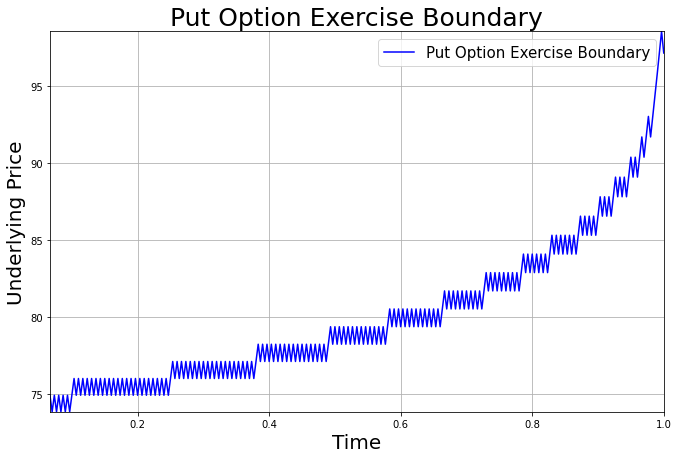

European Price = 7.459

American Price = 7.971

Printing value functions for various time steps
	Time step: 0


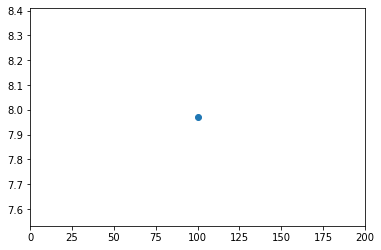

	Time step: 50


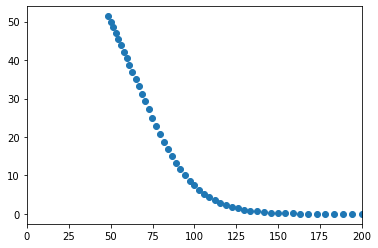

	Time step: 100


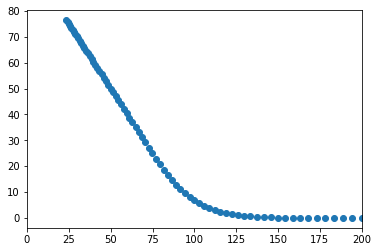

	Time step: 150


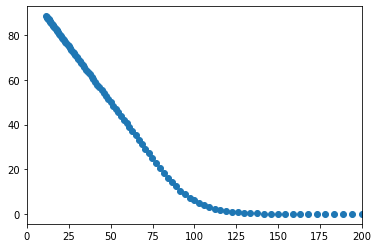

	Time step: 200


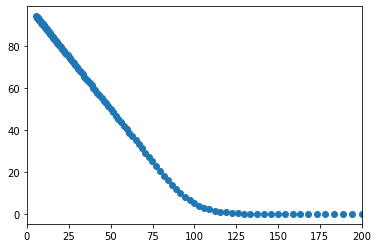

	Time step: 250


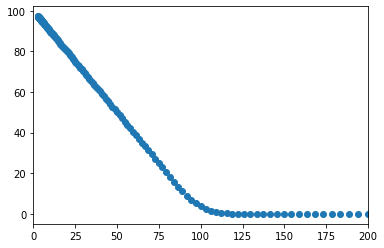

	Time step: 300


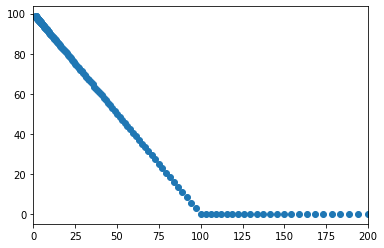

In [3]:
from rl.gen_utils.plot_funcs import plot_list_of_curves

# parameters
spot_price_val: float = 100.0 #100.0
strike: float = 100.0 #100.0
is_call: bool = False  #False
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 300 #300

# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

# instantiate the binary tree class defined above
opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

# get the optimal value functions and policy for each time step using backward induction
vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())

# get the exercise boundary
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)

# polt the exercise boundary as a function of time
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

# print the price of the european option (bs)
european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}\n")

# print the price of the american option (VF at state 0, at time 0)
am_price: float = vf_seq[0][NonTerminal(0)]
print(f"American Price = {am_price:.3f}\n")

# print value function for certain time steps
print("Printing value functions for various time steps")
for i in range(301):
    if i%50 == 0:
        print("\tTime step: {}".format(i))
        y = [vf_seq[i][NonTerminal(j)] for j in range(len(vf_seq[i]))]
        x =  [opt_ex_bin_tree.state_price(i,j) for j in range(len(vf_seq[i]))]
        plt.figure()
        plt.scatter(x,y)
        plt.xlim(0,200)
        plt.show()


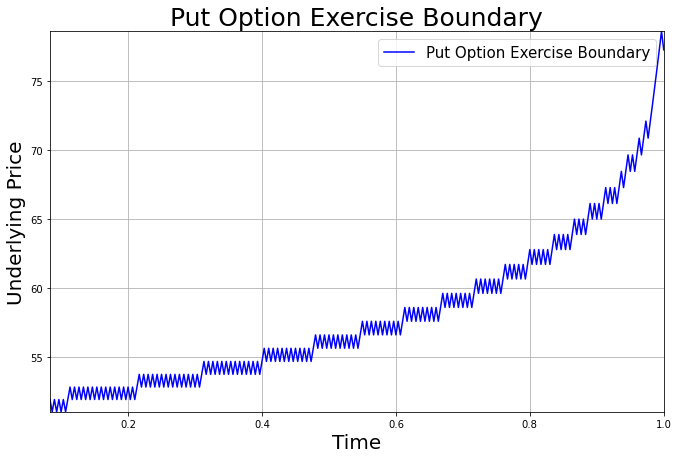

European Price = 8.262

American Price = 8.482

Printing value functions for various time steps
	Time step: 0


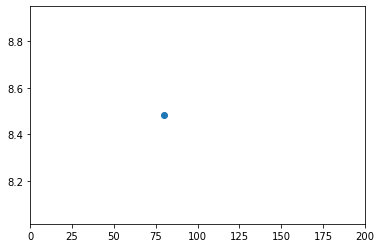

	Time step: 50


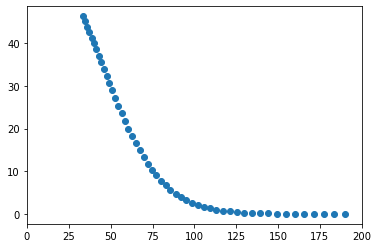

	Time step: 100


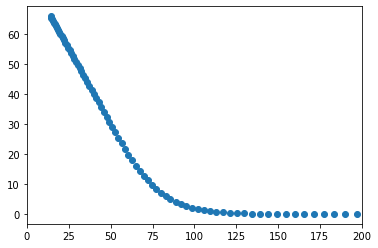

	Time step: 150


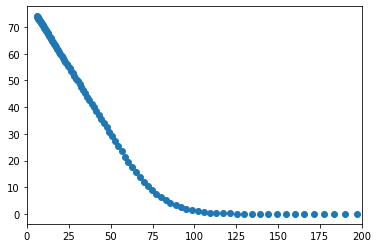

	Time step: 200


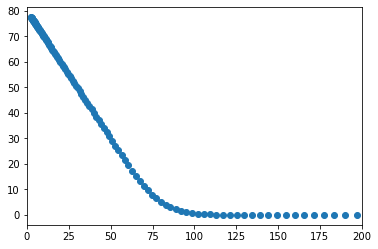

	Time step: 250


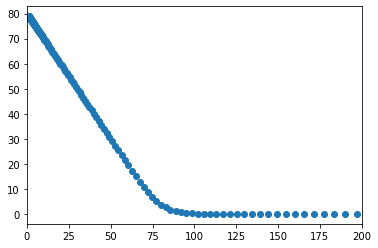

	Time step: 300


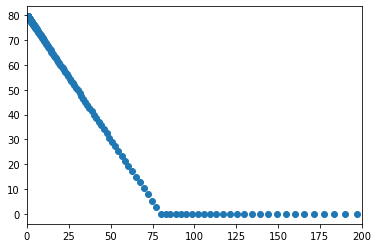

In [5]:
from rl.gen_utils.plot_funcs import plot_list_of_curves

# parameters
spot_price_val: float = 80.0 #100.0
strike: float = 80.0 #100.0
is_call: bool = False  #False
expiry_val: float = 1.0 #1.0
rate_val: float = 0.03 #0.05
vol_val: float = 0.3 #0.25
num_steps_val: int = 300 #300

# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

# instantiate the binary tree class defined above
opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

# get the optimal value functions and policy for each time step using backward induction
vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())

# get the exercise boundary
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)

# polt the exercise boundary as a function of time
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

# print the price of the european option (bs)
european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}\n")

# print the price of the american option (VF at state 0, at time 0)
am_price: float = vf_seq[0][NonTerminal(0)]
print(f"American Price = {am_price:.3f}\n")

# print value function for certain time steps
print("Printing value functions for various time steps")
for i in range(301):
    if i%50 == 0:
        print("\tTime step: {}".format(i))
        y = [vf_seq[i][NonTerminal(j)] for j in range(len(vf_seq[i]))]
        x =  [opt_ex_bin_tree.state_price(i,j) for j in range(len(vf_seq[i]))]
        plt.figure()
        plt.scatter(x,y)
        plt.xlim(0,200)
        plt.show()


C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book\rl\gen_utils\plot_funcs.py:26: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  max(map(max, list_of_y_vals))
C:\Users\frede\MCF_Workspace\cme291-aut21\RL-book\rl\gen_utils\plot_funcs.py:26: UserWarning: Attempting to set identical bottom == top == 102.9288218606067 results in singular transformations; automatically expanding.
  max(map(max, list_of_y_vals))


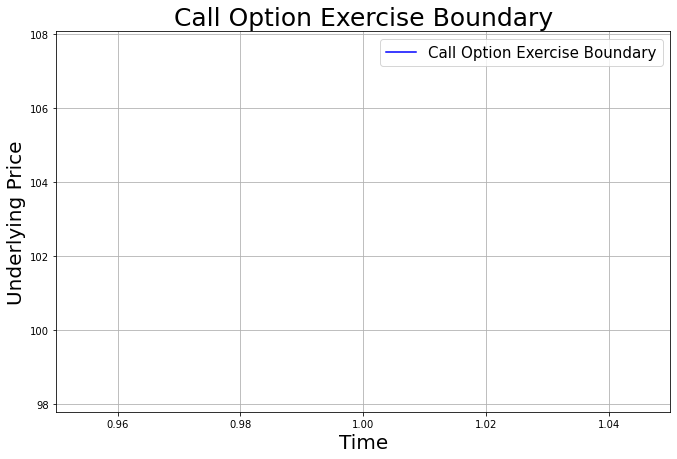

European Price = 12.336

American Price = 12.328

Printing value functions for various time steps
	Time step: 0


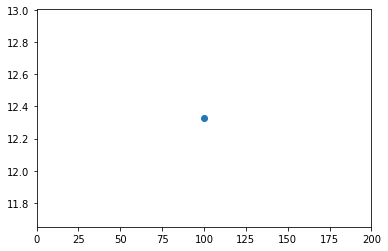

	Time step: 50


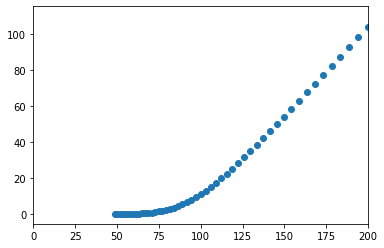

	Time step: 100


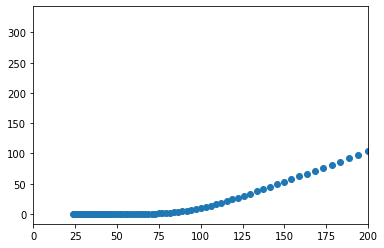

	Time step: 150


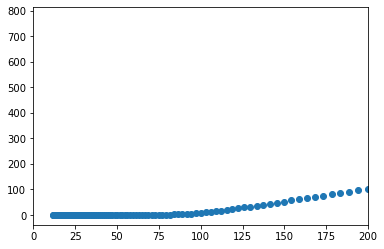

	Time step: 200


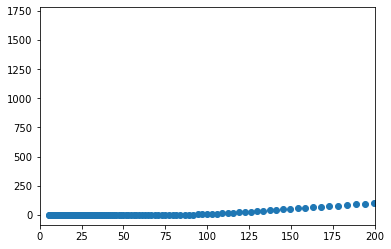

	Time step: 250


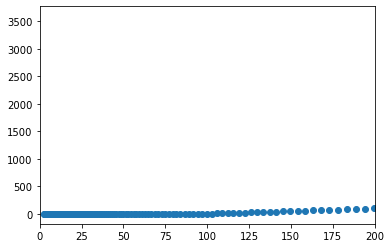

	Time step: 300


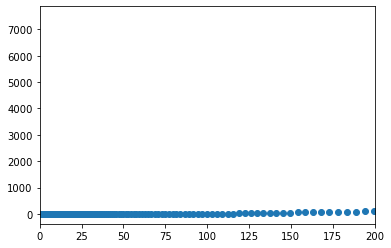

In [5]:
from rl.gen_utils.plot_funcs import plot_list_of_curves

# parameters
spot_price_val: float = 100.0 #100.0
strike: float = 100.0 #100.0
is_call: bool = True  #False
expiry_val: float = 1.0 #1.0
rate_val: float = 0.05 #0.05
vol_val: float = 0.25 #0.25
num_steps_val: int = 300 #300

# define different payoffs if call or put option
if is_call:
    opt_payoff = lambda _, x: max(x - strike, 0)
else:
    opt_payoff = lambda _, x: max(strike - x, 0)

# instantiate the binary tree class defined above
opt_ex_bin_tree: OptimalExerciseBinTree = OptimalExerciseBinTree(
    spot_price=spot_price_val,
    payoff=opt_payoff,
    expiry=expiry_val,
    rate=rate_val,
    vol=vol_val,
    num_steps=num_steps_val
)

# get the optimal value functions and policy for each time step using backward induction
vf_seq, policy_seq = zip(*opt_ex_bin_tree.get_opt_vf_and_policy())

# get the exercise boundary
ex_boundary: Sequence[Tuple[float, float]] = \
    opt_ex_bin_tree.option_exercise_boundary(policy_seq, is_call)

# polt the exercise boundary as a function of time
time_pts, ex_bound_pts = zip(*ex_boundary)
label = ("Call" if is_call else "Put") + " Option Exercise Boundary"
plot_list_of_curves(
    list_of_x_vals=[time_pts],
    list_of_y_vals=[ex_bound_pts],
    list_of_colors=["b"],
    list_of_curve_labels=[label],
    x_label="Time",
    y_label="Underlying Price",
    title=label
)

# print the price of the european option (bs)
european: float = opt_ex_bin_tree.european_price(is_call, strike)
print(f"European Price = {european:.3f}\n")

# print the price of the american option (VF at state 0, at time 0)
am_price: float = vf_seq[0][NonTerminal(0)]
print(f"American Price = {am_price:.3f}\n")

# print value function for certain time steps
print("Printing value functions for various time steps")
for i in range(301):
    if i%50 == 0:
        print("\tTime step: {}".format(i))
        y = [vf_seq[i][NonTerminal(j)] for j in range(len(vf_seq[i]))]
        x =  [opt_ex_bin_tree.state_price(i,j) for j in range(len(vf_seq[i]))]
        plt.figure()
        plt.scatter(x,y)
        plt.xlim(0,200)
        plt.show()
